In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import csv
from datetime import datetime as dt
import seaborn as sns
from networkx.algorithms import bipartite
from collections import Counter
from sklearn.cluster import KMeans

In [2]:
interactions_train = pd.read_csv('interactions_train.csv', engine='python', on_bad_lines='skip')
interactions_test = pd.read_csv('interactions_test.csv', engine='python', on_bad_lines='skip')
interactions_validation = pd.read_csv('interactions_validation.csv', engine='python', on_bad_lines='skip')
interactions = pd.concat([interactions_train, interactions_test, interactions_validation], axis=0, join='outer')
users = pd.read_csv('PP_users.csv', engine='python', on_bad_lines='skip')
recipes = pd.read_csv('RAW_recipes.csv', engine='python', on_bad_lines='skip')

In [3]:
# Interactions EDA
# user_id - User ID
# recipe_id - Recipe ID
# date - Date of interaction between user and recipe
# rating - User's rating given for the recipe
# review - User's review text for the recipe u = User ID, mapped to contiguous integers from 0 
# i = Recipe ID, mapped to contiguous integers from 0

interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 718379 entries, 0 to 7022
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    718379 non-null  int64  
 1   recipe_id  718379 non-null  int64  
 2   date       718379 non-null  object 
 3   rating     718379 non-null  float64
 4   u          718379 non-null  int64  
 5   i          718379 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 38.4+ MB


In [4]:
# convert to DateTime object
interactions['date'] = pd.to_datetime(interactions['date'])

In [6]:
# Recipes EDA
# name - Recipe name
# id - Recipe ID
# minutes - Minutes to prepare recipe
# contributor_id - User ID who submitted this recipe
# submitted - Date the recipe was submitted
# tags - Food.com tags for recipe
# nutrition - Nutrition info: [calories, total fat (PDV), sugar (PDV), sodium (PDV), protein (PDV), saturated fat]
# (PDV = percent daily value)
# n_steps - Number of steps in recipe
# steps - Text for recipe steps in order
# description - Contributor-provided description

# since we're most likely not doing anything with the 'steps' or 'description' columns, we'll simply remove them
recipes = recipes.drop(['steps', 'description'], axis=1)

# there's one row whose 'name' entry is 'NaN' which could cause issues, so we can remove that
recipes = recipes.dropna().reset_index()

KeyError: "['steps', 'description'] not found in axis"

In [10]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231636 entries, 0 to 231635
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           231636 non-null  int64 
 1   name            231636 non-null  object
 2   id              231636 non-null  int64 
 3   minutes         231636 non-null  int64 
 4   contributor_id  231636 non-null  int64 
 5   submitted       231636 non-null  object
 6   tags            231636 non-null  object
 7   nutrition       231636 non-null  object
 8   n_steps         231636 non-null  int64 
 9   ingredients     231636 non-null  object
 10  n_ingredients   231636 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 19.4+ MB


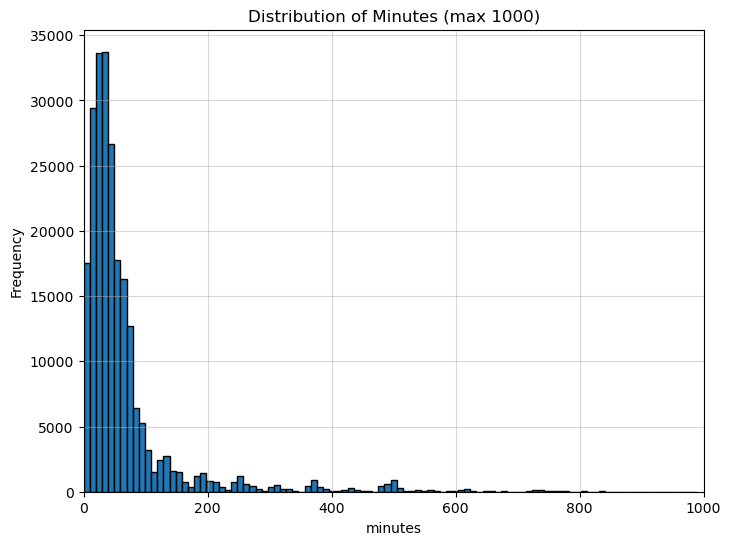

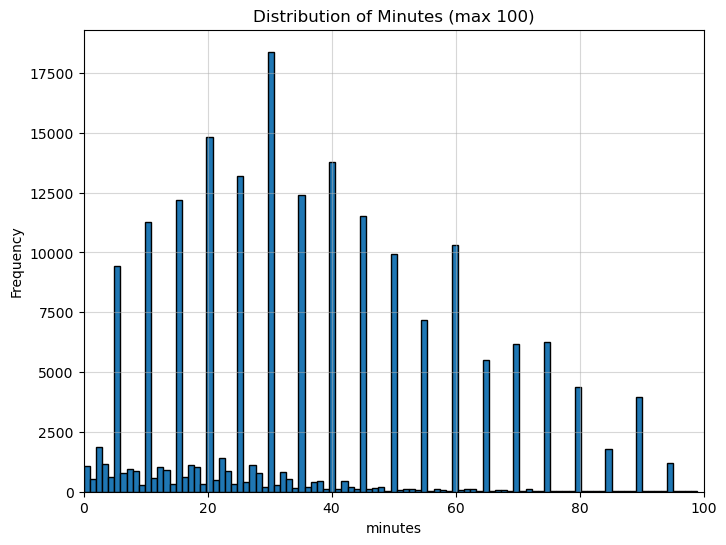

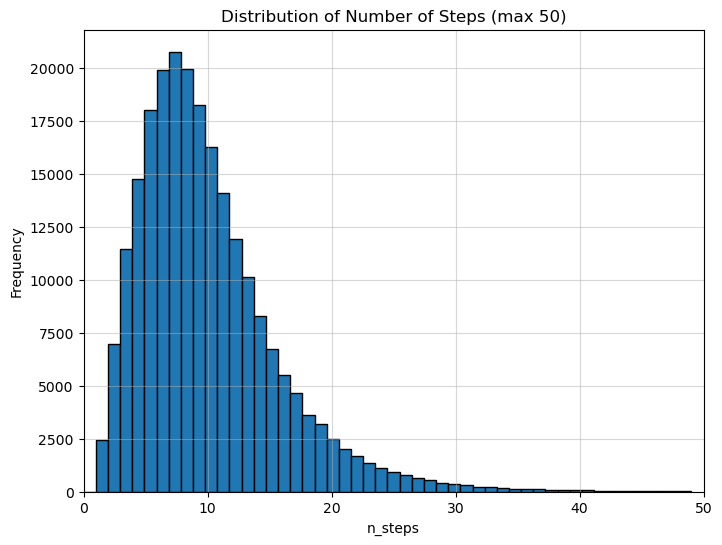

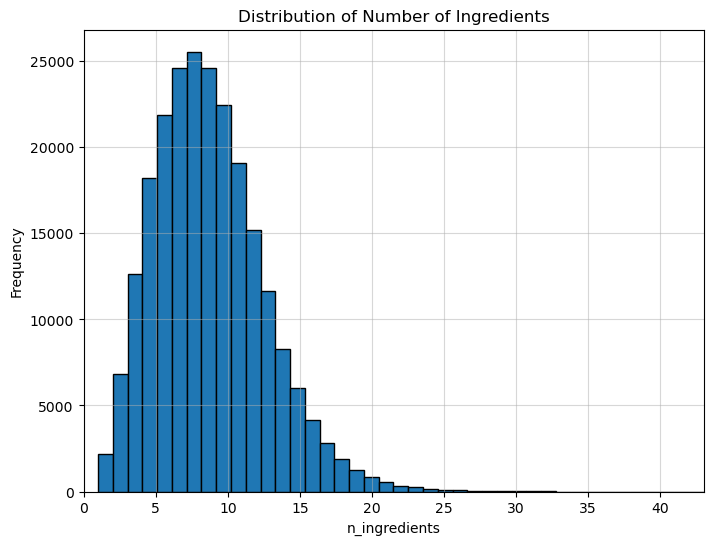

In [11]:
# convert 'submitted' variable from string to date object
recipes['submitted'] = pd.to_datetime(recipes['submitted'])

# Select numerical columns for visualization, and define ranges and bins for each
cols = [recipes[recipes['minutes'] < 1000]['minutes'],
        recipes[recipes['minutes'] < 100]['minutes'],
        recipes[recipes['n_steps'] < 50]['n_steps'],
        recipes['n_ingredients']]
col_names = ['minutes', 'minutes', 'n_steps', 'n_ingredients']
bins = [100, 100, 50, len(recipes['n_ingredients'].unique())]
titles = ['Distribution of Minutes (max 1000)',
          'Distribution of Minutes (max 100)',
          'Distribution of Number of Steps (max 50)',
          'Distribution of Number of Ingredients']
xlims = [1000, 100, 50, np.max(recipes['n_ingredients'])]

# Define a function that takes in details of a histogram plot and plots it

def plot_histograms(col, col_name, bins, title, xlim):
    plt.figure(figsize=(8, 6))
    plt.hist(col, bins=bins, edgecolor='black')
    plt.xlabel(col_name)
    plt.ylabel('Frequency')
    plt.xlim(0, xlim)
    plt.title(title)
    plt.grid(True, alpha=0.5)
    plt.show()

# Create histograms for each numerical column

for col, col_name, bins, title, xlim in zip(cols, col_names, bins, titles, xlims):
    plot_histograms(col, col_name, bins, title, xlim)

In [12]:
# Make tags a list 
n_recipes = len(recipes)
tags = recipes['tags'].copy()

for i in range(0, n_recipes):
  tags[i] = eval(recipes['tags'][i])

recipes['tags'] = tags

In [13]:
tags_raw = {}

for taglist in recipes.tags:
    for tag in taglist:
        if tag not in tags_raw:
            tags_raw[tag] = 1
        else:
            tags_raw[tag] += 1

print('There are ', len(tags_raw), 'tags in total.')

There are  552 tags in total.


In [14]:
# we can see some categories of tags
# I omitted some tags that were too vague like 'preparation' or 'course'

# CUISINE
  # north-american, mexican, american, northeastern-united-states, amish-mennonite, canadian, south-west-pacific, hawaiian, southwestern-united-states, asian, indian
  # californian, german, european, italian, midwestern, southern-united-states, indonesian, pacific-northwest, polish, chinese, british-columbian, danish, scandinavian
  # swiss, swedish, french, african, creole, cajun, australian, caribbean, central-american, english, quebec, middle-eastern, lebanese, greek, south-american
  # russian, baja, japanese, native-american, spanish, irish, polynesian, thai, ontario, tex-mex, south-african, new-zealand, pennsylvania-dutch, welsh, filipino, cuban
  # korean, belgian, finnish, moroccan, iranian, persian, dutch, turkish, portuguese, hungarian, brazilian, egyptian, vietnamese, norwegian, austrian, soul
# FOOD CATEGORIES
  # meats/animal products
    # meat, pork, pork-ribs, pork-chops, beef, poultry, chicken, ground-beef, wild-game, deer, chicken-breasts, beef-ribs, bacon, turkey, whole-turkey, beef-sausage
    # steak, steaks, roast-beef, pork-sausage, wings, pork-loins, ham, lamb-sheep, whole-chicken, turkey-breasts, duck, chicken-thighs-and-legs, veal
    # gelatin, eggs, eggs-dairy, cheese
  # seafood
    # seafood, fish, tuna, saltwater-fish, salmon, no-shell-fish, shrimp, shellfish, crab, freshwater-fish, catfish, clams, halibut, scallops, tilapia, cod
    # sole-and-flounder, mussels, oysters, lobster
  # vegetables and fruits bc idk which belong to which: vegetables, fruit, greens, salads, tropical-fruit, squash, chili, potatoes, apples, bananas, berries, strawberries, beans
    # cauliflower, spinach, peppers, black-beans, nuts, pineapple, corn, grapes, soy-tofu, tomatoes, onions, broccoli, lettuces, lentils, asparagus, simply-potatoes
    # mango, green-yellow-beans, coconut, citrus, oranges, papaya, pitted-fruit, peaches, blueberries, zucchini, lemon, chick-peas-garbanzos, carrots, yams-sweet-potatoes
    # lime, melons, raspberries, pears, cherries, plums
  # drinks
    # beverages, shakes, smoothies, cocktails, punch
  # desserts
    # desserts, frozen-desserts, baking, cooking-mixes, pies-and-tarts, pies, chocolate, candy, cookies-and-brownies, bar-cookies, brownies, muffins
    # cakes, cheesecake, pancakes-and-waffles, rolled-cookies, drop-cookies, savory-pies, fudge, biscotti, puddings-and-mousses, cobblers-and-crisps
    # cupcakes, hand-formed-cookies, scones, crusts-pastry-dough, coffee-cakes, tarts, cake-fillings-and-frostings
  # soups, stews
    # stews, stocks, bisques-cream-soups, soups-stews, clear-soups, gumbo, chowders
  # grains, pastas, breads
    # pasta, pasta-rice-and-grains, breads, quick-breads, grains, rice, brown-rice, white-rice, long-grain-rice, short-grain-rice, elbow-macaroni, spaghetti, ravioli-tortellini
    # rolls-biscuits, pasta-shells, penne
  # general foods
    # pizza, sandwiches, lasagna, omelets-and-frittatas, finger-food, casseroles, granola-and-porridge, burgers, manicotti
  # fungi
    # mushrooms, yeast
  # sauces and spreads and such
    # sauces, sweet-sauces, savory-sauces, spreads, dips, salad-dressings, curries, peanut-butter, salsas, chutneys, jams-and-preserves
    # jellies, stuffings-dressings, marinades-and-rubs
  # herby, garnishy things
    # herb-and-spice-mixes, garnishes
# TIME TO MAKE
  # 15-minutes-or-less, 30-minutes-or-less, 60-minutes-or-less, 4-hours-or-less, 1-day-or-more
# TYPE OF DISH
  # side-dishes, main-dish, appetizers, one-dish-meal
# TIME OF YEAR
  # spring, summer, fall, winter, seasonal
# HOLIDAYS
  # holiday-event, christmas, easter, new-years, thanksgiving, independence-day, st-patricks-day, valentines-day, superbowl, super-bowl, halloween, birthday
# TIME OF DAY
  # breakfast, brunch, lunch, dinner-party, snacks
# EVENTS
  # for-large-groups, for-1-or-2, potluck, picnic, barbecue, wedding, camping
# DIET SPECIFICS
  # vegan, vegetarian, low-protein, low-sodium, low-calorie, low-fat, low-in-something, healthy, lactose, free-of-something, low-cholesterol, low-carb, healthy-2, low-saturated fat
  # high-calcium, high-protein, high-in-something, very-low-carbs, gluten-free, diabetic, egg-free, dairy-free, high-fiber, non-alcoholic, nut-free,
# APPLIANCES/TECHNIQUES
  # oven, crock-pot-slow-cooker, stove-top, freezer, no-cook, refrigerator, oamc-freezer-make-ahead, deep-fry, food-processor-blender, small-appliance, grilling, mixer
  # roast, broil, barbecue, steam, microwave, bread-machine, stir-fry, pressure-cooker, water-bath,
# RELIGIONS
  # jewish-sephardi, jewish-ashkenazi, kosher, ramadan, kwanzaa, hanukkah, rosh-hashana, mardi-gras-carnival, passover
# other
  # kid-friendly, toddler-friendly, infant-baby-friendly, inexpensive, served-hot, served-cold, novelty, spicy, savory, sweet, comfort-food, to-go, gifts, romantic
  # leftovers, brown-bag, celebrity, easy, beginner-cook, 5-ingredients-or-less, 3-steps-or-less

In [15]:
# Ingredients
# Make list 

n_recipes = len(recipes)
ingredients = recipes['ingredients'].copy()

for i in range(0, n_recipes):
  ingredients[i] = eval(recipes['ingredients'][i])

recipes['ingredients'] = ingredients

In [16]:
ingredients_raw = {}

for ing_list in recipes.ingredients:
    for ingredient in ing_list:
        if ingredient not in ingredients_raw:
            ingredients_raw[ingredient] = 1
        else:
            ingredients_raw[ingredient] += 1

print('There are ', len(ingredients_raw), 'ingredients in total.')

There are  14942 ingredients in total.


In [17]:
# Users EDA 

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25076 entries, 0 to 25075
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   u           25076 non-null  int64 
 1   techniques  25076 non-null  object
 2   items       25076 non-null  object
 3   n_items     25076 non-null  int64 
 4   ratings     25076 non-null  object
 5   n_ratings   25076 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.1+ MB


In [18]:
# Make items a list
n_users = len(users)
user_items = users['items'].copy()

for i in range(0, n_users):
  user_items[i] = eval(users['items'][i])

users['items'] = user_items

In [20]:
# it's currently a little cumbersome to use the users data since it only contains the processed user ID,
# and the recipes data only contains the unprocessed user/recipe IDs
# first, we can append to the users a data a new column 'user_id' containing the unprocessed user IDs.
users = pd.concat([users, interactions.groupby('u').first().reset_index()['user_id']], axis=1, join='outer')

In [21]:
# then, we can append a new column 'recipe_ids' containing the unprocessed recipe IDs.
# dict format is
  # processed recipe ID : unprocessed recipe ID

recipe_ids_dict = {}

interactions_unique_recipes = interactions.groupby('recipe_id').first().reset_index()
num_unique_recipes_interactions = len(interactions_unique_recipes)

for i in range(0, num_unique_recipes_interactions):
  recipe_ids_dict[interactions_unique_recipes['i'][i]] = interactions_unique_recipes['recipe_id'][i]

recipe_ids = []

for item_list in users['items']:
  new_list = []
  for item in item_list:
    new_list.append(recipe_ids_dict[item])
  recipe_ids.append(new_list)

users = pd.concat([users, pd.Series(recipe_ids)], axis=1, join='outer')
users.rename(columns={0:'recipe_ids'}, inplace=True)

In [23]:
# Build bipartite graphs 

def process_ingredients(ingredients_str):
    # Split by comma and strip whitespace
    return [ing.strip() for ing in ingredients_str.split(',') if ing.strip()]

def build_bipartite_graph(df):
    B = nx.Graph()
    recipe_nodes = df['id'].tolist()
    B.add_nodes_from(recipe_nodes, bipartite='recipes')

    ingredient_set = set()

    # iterate over each recipe, add ingredient nodes & connect them
    for idx, row in df.iterrows():
        recipe = row['id']
        ingredients = row['ingredients']

        if isinstance(ingredients, str):
            ingredients_list = process_ingredients(ingredients)
        elif isinstance(ingredients, list):
            ingredients_list = ingredients
        else:
            ingredients_list = []

        # for each ingredient, add an edge between the recipe & ingredient node
        for ing in ingredients_list:
            ingredient_set.add(ing)
            B.add_edge(recipe, ing)

    B.add_nodes_from(list(ingredient_set), bipartite='ingredients')
    print("Bipartite graph has {} nodes and {} edges".format(B.number_of_nodes(), B.number_of_edges()))
    return B

In [24]:
### visualizations

def visualize_bipartite_network(B):
    recipes = {n for n, d in B.nodes(data=True) if 'bipartite' in d and d['bipartite'] == 'recipes'}
    ingredients = set(B) - recipes

    pos = nx.bipartite_layout(B, recipes)
    plt.figure(figsize=(12, 8))

    # recipe nodes (left side)
    nx.draw_networkx_nodes(B, pos,
                           nodelist=list(recipes),
                           node_color='lightblue',
                           node_size=200,
                           alpha=0.8)

    # ingredient nodes (right side)
    nx.draw_networkx_nodes(B, pos,
                           nodelist=list(ingredients),
                           node_color='lightgreen',
                           node_size=100,
                           alpha=0.8)
    #  edges
    nx.draw_networkx_edges(B, pos, width=1.0, alpha=0.5)

    # labels - use recipe names instead of IDs if available
    recipe_labels = {node: node for node in recipes}
    ingredient_labels = {node: node for node in ingredients}
    labels = {**recipe_labels, **ingredient_labels}

    nx.draw_networkx_labels(B, pos,
                           labels={n: labels[n] for n in recipes},
                           font_size=8,
                           font_weight='bold')

    nx.draw_networkx_labels(B, pos,
                           labels={n: labels[n] for n in ingredients},
                           font_size=7)

    plt.title("Recipe-Ingredient Bipartite Network")
    plt.axis('off')
    plt.tight_layout()
    return plt


def visualize_large_bipartite_network(B, recipe_name_map=None):
    """ Create a cleaner visualization for larger bipartite networks.
    - B: The bipartite graph
    - recipe_name_map: Optional dictionary mapping recipe IDs to readable names
    """
    recipes = {n for n, d in B.nodes(data=True) if 'bipartite' in d and d['bipartite'] == 'recipes'}
    ingredients = set(B) - recipes
    pos = nx.spring_layout(B, k=0.5)  # k controls spacing
    plt.figure(figsize=(14, 10))

    # recipe nodes
    nx.draw_networkx_nodes(B, pos,
                          nodelist=list(recipes),
                          node_color='royalblue',
                          node_size=500,
                          alpha=0.7)

    # ingredient nodes
    nx.draw_networkx_nodes(B, pos,
                          nodelist=list(ingredients),
                          node_color='lightgreen',
                          node_size=200,
                          alpha=0.7)
    # edges
    nx.draw_networkx_edges(B, pos, width=0.5, alpha=0.4, edge_color='gray')

    # labels
    if recipe_name_map:
        recipe_labels = {node: recipe_name_map.get(node, str(node)) for node in recipes}
    else:
        recipe_labels = {node: str(node) for node in recipes}

    # only show ingredient labels if there aren't too many
    if len(ingredients) < 30:
        ingredient_labels = {node: str(node) for node in ingredients}
        nx.draw_networkx_labels(B, pos,
                               labels=ingredient_labels,
                               font_size=8,
                               font_color='darkgreen')
    # show recipe labels
    nx.draw_networkx_labels(B, pos,
                           labels=recipe_labels,
                           font_size=8,
                           font_color='black')

    plt.title("Recipe-Ingredient Bipartite Network", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    return plt

In [25]:
### analysis

def create_projections(B, weighted=True):
    """Create the 2  projections (onto recipes & ingredients) of bipartite graph B."""
    recipes = {n for n, d in B.nodes(data=True) if 'bipartite' in d and d['bipartite'] == 'recipes'}
    ingredients = set(B) - recipes

    if weighted:
        # based on number of common connections
        recipe_projection = nx.bipartite.weighted_projected_graph(B, recipes)
        ingredient_projection = nx.bipartite.weighted_projected_graph(B, ingredients)

    else:
        recipe_projection = nx.bipartite.projected_graph(B, recipes)
        ingredient_projection = nx.bipartite.projected_graph(B, ingredients)

    return recipe_projection, ingredient_projection


def analyze_projections(recipe_proj, ingredient_proj):
    """Analyze both projection graphs and return key metrics."""
    results = {}

    # Recipe projection analysis
    results['recipes'] = {
        'nodes': recipe_proj.number_of_nodes(),
        'edges': recipe_proj.number_of_edges(),
        'density': nx.density(recipe_proj),
        'avg_weight': np.mean([d['weight'] for u, v, d in recipe_proj.edges(data=True)]),
        'max_weight': max([d['weight'] for u, v, d in recipe_proj.edges(data=True)]) if recipe_proj.edges else 0,
        'connected_components': nx.number_connected_components(recipe_proj),
        'clustering_coef': nx.average_clustering(recipe_proj, weight='weight'),
        'degree_centrality': nx.degree_centrality(recipe_proj),
        'weighted_degree': {node: sum(w for _, _, w in recipe_proj.edges(node, data='weight'))
                            for node in recipe_proj.nodes()}
    }

    # Ingredient projection analysis
    results['ingredients'] = {
        'nodes': ingredient_proj.number_of_nodes(),
        'edges': ingredient_proj.number_of_edges(),
        'density': nx.density(ingredient_proj),
        'avg_weight': np.mean([d['weight'] for u, v, d in ingredient_proj.edges(data=True)]),
        'max_weight': max([d['weight'] for u, v, d in ingredient_proj.edges(data=True)]) if ingredient_proj.edges else 0,
        'connected_components': nx.number_connected_components(ingredient_proj),
        'clustering_coef': nx.average_clustering(ingredient_proj, weight='weight'),
        'degree_centrality': nx.degree_centrality(ingredient_proj),
        'weighted_degree': {node: sum(w for _, _, w in ingredient_proj.edges(node, data='weight'))
                           for node in ingredient_proj.nodes()}
    }
    return results


def visualize_projections(recipe_proj, ingredient_proj, recipe_name_map=None):
    """Create visualizations for both projection graphs."""

    # helper function: create better layout for weighted graphs
    def create_weighted_layout(G):
        pos = nx.kamada_kawai_layout(G)
        return pos

    ### ----- 1. Recipe Projection Visualization
    plt.figure(figsize=(10, 8))
    pos_recipes = create_weighted_layout(recipe_proj)

    # get edge weights for width
    edge_weights = [d['weight'] for u, v, d in recipe_proj.edges(data=True)]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_widths = [2.0 * w / max_weight for w in edge_weights]

    # get node degrees for size
    node_degrees = [recipe_proj.degree(n, weight='weight') for n in recipe_proj.nodes()]
    max_degree = max(node_degrees) if node_degrees else 1
    node_sizes = [300 * (d / max_degree) + 100 for d in node_degrees]

    nx.draw_networkx_nodes(recipe_proj, pos_recipes, node_size=node_sizes,
                          node_color='lightblue', alpha=0.8)
    nx.draw_networkx_edges(recipe_proj, pos_recipes, width=edge_widths,
                          alpha=0.3, edge_color='navy')

    weighted_degrees = {node: sum(w for _, _, w in recipe_proj.edges(node, data='weight'))
                        for node in recipe_proj.nodes()}

    # label top N recipes, by weighted degree
    top_n = min(3, len(recipe_proj.nodes()))
    top_recipes = sorted(weighted_degrees.keys(),
                        key=lambda x: weighted_degrees[x], reverse=True)[:top_n]
    if recipe_name_map:
        labels = {node: recipe_name_map.get(node, str(node)) for node in top_recipes}
    else:
        labels = {node: str(node) for node in top_recipes}

    nx.draw_networkx_labels(recipe_proj, pos_recipes, labels=labels, font_size=8)

    plt.title("Recipe Projection (Connected by Common Ingredients)")
    plt.axis('off')
    plt.tight_layout()
    # plt.savefig('recipe_projection.png', dpi=300)
    # -------------------------------------------

    ### ----- 2. Ingredient Projection Visualization
    plt.figure(figsize=(12, 10))
    pos_ingredients = create_weighted_layout(ingredient_proj)

    # only visualize edges w/ weight above a threshold, if there are too many
    if ingredient_proj.number_of_edges() > 100:
        weight_threshold = np.mean([d['weight'] for u, v, d in ingredient_proj.edges(data=True)])
        filtered_edges = [(u, v) for u, v, d in ingredient_proj.edges(data=True)
                          if d['weight'] > weight_threshold]
        filtered_weights = [d['weight'] for u, v, d in ingredient_proj.edges(data=True)
                           if d['weight'] > weight_threshold]
    else:
        filtered_edges = [(u, v) for u, v in ingredient_proj.edges()]
        filtered_weights = [d['weight'] for u, v, d in ingredient_proj.edges(data=True)]

    max_weight = max(filtered_weights) if filtered_weights else 1
    edge_widths = [1.5 * w / max_weight for w in filtered_weights]

    # get node degrees for size
    node_degrees = [ingredient_proj.degree(n, weight='weight') for n in ingredient_proj.nodes()]
    max_degree = max(node_degrees) if node_degrees else 1
    node_sizes = [250 * (d / max_degree) + 50 for d in node_degrees]

    nx.draw_networkx_nodes(ingredient_proj, pos_ingredients, node_size=node_sizes,
                          node_color='lightgreen', alpha=0.4)
    nx.draw_networkx_edges(ingredient_proj, pos_ingredients, edgelist=filtered_edges,
                          width=edge_widths, alpha=0.7, edge_color='forestgreen')

    # label the most important ingredients (by degree)
    if len(ingredient_proj.nodes()) > 20:
        weighted_degrees = {node: sum(w for _, _, w in ingredient_proj.edges(node, data='weight'))
                            for node in ingredient_proj.nodes()}
        top_ingredients = sorted(weighted_degrees.keys(),
                                key=lambda x: weighted_degrees[x], reverse=True)[:20]
        labels = {node: str(node) for node in top_ingredients}
    else:
        labels = {node: str(node) for node in ingredient_proj.nodes()}

    nx.draw_networkx_labels(ingredient_proj, pos_ingredients, labels=labels, font_size=8)

    plt.title("Ingredient Projection (Connected by Common Recipes)")
    plt.axis('off')
    plt.tight_layout()
    # plt.savefig('ingredient_projection.png', dpi=300)
    return


def matrix_analysis(B):
    """ matrix-based analysis of the bipartite network."""

    # get the two sets of nodes
    recipes = {n for n, d in B.nodes(data=True) if 'bipartite' in d and d['bipartite'] == 'recipes'}
    ingredients = set(B) - recipes

    recipe_list = list(recipes)
    ingredient_list = list(ingredients)

    # 1. create biadjacency matrix
    biadjacency = nx.bipartite.biadjacency_matrix(B, recipes, ingredient_list)

    # 2. create the two projection matrices explicitly
    ###  Recipe projection: A * A^T
    recipe_matrix = biadjacency.dot(biadjacency.transpose())
    ###  Ingredient projection: A^T * A
    ingredient_matrix = biadjacency.transpose().dot(biadjacency)

    # 3. format for analysis
    recipe_matrix_dense = recipe_matrix.todense()
    ingredient_matrix_dense = ingredient_matrix.todense()

    # 4. calc. eigenvalues & eigenvectors for community detection
    recipe_eigenvalues, recipe_eigenvectors = np.linalg.eigh(recipe_matrix_dense)
    ingredient_eigenvalues, ingredient_eigenvectors = np.linalg.eigh(ingredient_matrix_dense)

    # 5. sort eigenvalues & eigenvectors in descending order
    recipe_idx = np.argsort(recipe_eigenvalues)[::-1]
    recipe_eigenvalues = recipe_eigenvalues[recipe_idx]
    recipe_eigenvectors = recipe_eigenvectors[:, recipe_idx]

    ingredient_idx = np.argsort(ingredient_eigenvalues)[::-1]
    ingredient_eigenvalues = ingredient_eigenvalues[ingredient_idx]
    ingredient_eigenvectors = ingredient_eigenvectors[:, ingredient_idx]

    ### ----- Identify ingredient clusters -----
    # using top eigenvectors for ingredient clustering
    n_clusters = min(4, len(ingredient_list))  # maximum number of clusters
    cluster_vectors = ingredient_eigenvectors[:, :n_clusters]

    # kmeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    ingredient_clusters = kmeans.fit_predict(cluster_vectors)

    # dictionary mapping ingredients to clusters, count items in each cluster
    ingredient_cluster_map = {ingredient_list[i]: ingredient_clusters[i] for i in range(len(ingredient_list))}
    cluster_counts = Counter(ingredient_clusters)

    # find most central ingredients in each cluster
    central_ingredients = {}
    for cluster_id in range(n_clusters):
        cluster_ingredients = [ingredient_list[i] for i in range(len(ingredient_list))
                              if ingredient_clusters[i] == cluster_id]

        # ingredient with highest degree in the projection
        if cluster_ingredients:
            try:
                central_ingredient = max(cluster_ingredients,
                                       key=lambda x: sum(ingredient_matrix[ingredient_list.index(x), ingredient_list.index(y)]
                                                     for y in cluster_ingredients if y != x))
                central_ingredients[cluster_id] = central_ingredient
            except:
                # Fallback if error occurs
                central_ingredients[cluster_id] = cluster_ingredients[0]

    return {
        'biadjacency_shape': biadjacency.shape,
        'recipe_matrix_shape': recipe_matrix.shape,
        'ingredient_matrix_shape': ingredient_matrix.shape,
        'recipe_top_eigenvalues': recipe_eigenvalues[:5].tolist(),
        'ingredient_top_eigenvalues': ingredient_eigenvalues[:5].tolist(),
        'ingredient_clusters': ingredient_cluster_map,
        'cluster_counts': {f'cluster_{k}': v for k, v in cluster_counts.items()},
        'central_ingredients': {f'cluster_{k}': v for k, v in central_ingredients.items()}
    }

In [26]:
### --- filter recipes by tag, otherwise just set to False
filter_by_tag = True
keep_tags = ['healthy', 'sweet', 'breakfast']
# -------------------------------------------

df_recipes = recipes.copy()
if filter_by_tag:
    df_recipes = recipes[recipes.tags.apply(lambda x: any(tag in x for tag in keep_tags))]
    print(f"{len(df_recipes)} recipes with tags: {keep_tags}")

df_recipes = df_recipes[["name", "id", "ingredients", "tags"]]

59012 recipes with tags: ['healthy', 'sweet', 'breakfast']


In [27]:
# take a random subset of N recipes
n_recipes = 100
df_subset = df_recipes.sample(n=n_recipes, random_state=42)

B = build_bipartite_graph(df_subset)

Bipartite graph has 496 nodes and 826 edges


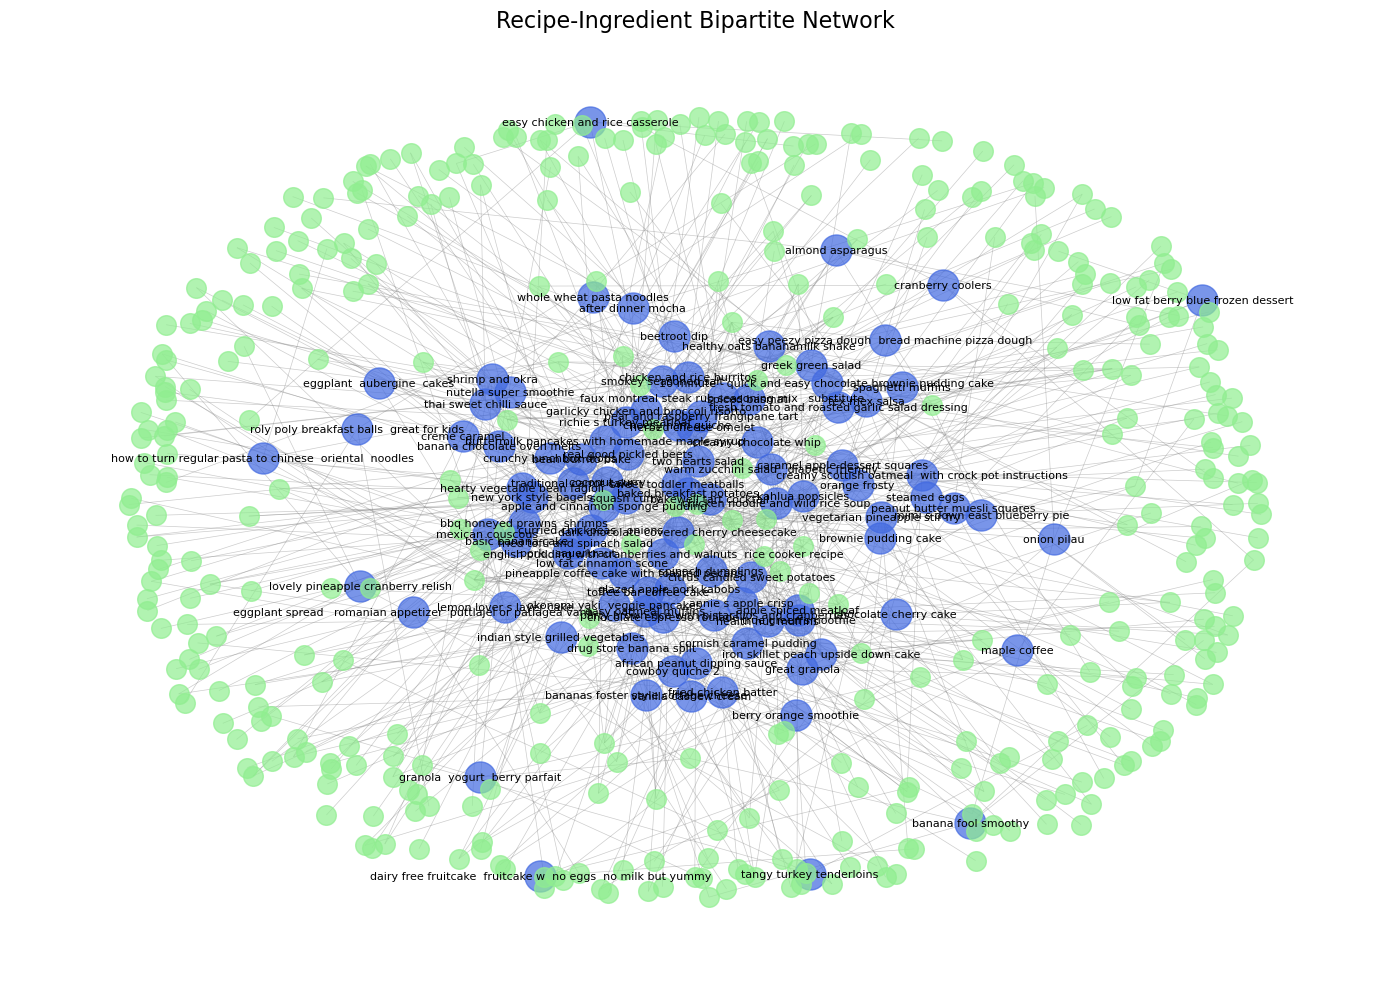

In [28]:
### larger network:
recipe_name_map = dict(zip(df_subset['id'], df_subset['name']))
plt = visualize_large_bipartite_network(B, recipe_name_map)
# plt.savefig('bipartite_network.png', dpi=300)
plt.show()

In [29]:
# --- function to run all analyses ---
def analyze_bipartite_network(B, recipe_name_map=None):
    """ Run full analysis on the bipartite network B."""

    # 1. Create projections
    recipe_proj, ingredient_proj = create_projections(B)

    # 2. Basic network analysis
    proj_analysis = analyze_projections(recipe_proj, ingredient_proj)

    # 3. Matrix analysis
    matrix_results = matrix_analysis(B)

    # 4. Visualize projections
    visualize_projections(recipe_proj, ingredient_proj, recipe_name_map)

    # 5. Return combined results
    return {
        'projections': {
            'recipe_projection': recipe_proj,
            'ingredient_projection': ingredient_proj
        },
        'analysis': proj_analysis,
        'matrix_analysis': matrix_results
    }

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


-------------------------
Recipe Projection Analysis:
- nodes: 100
- edges: 1691
- density: 0.3416161616161616
- avg_weight: 1.518628030751035
- max_weight: 7
- connected_components: 3
- clustering_coef: 0.1364861348379419
-------------------------
Ingredient Projection Analysis:
- nodes: 396
- edges: 3065
- density: 0.0391893619741721
- avg_weight: 1.1814029363784666
- max_weight: 15
- connected_components: 3
- clustering_coef: 0.06218042245966795
-------------------------
Top ingredients by weighted degree:
- salt: 380
- butter: 186
- eggs: 156
- water: 143
- brown sugar: 141


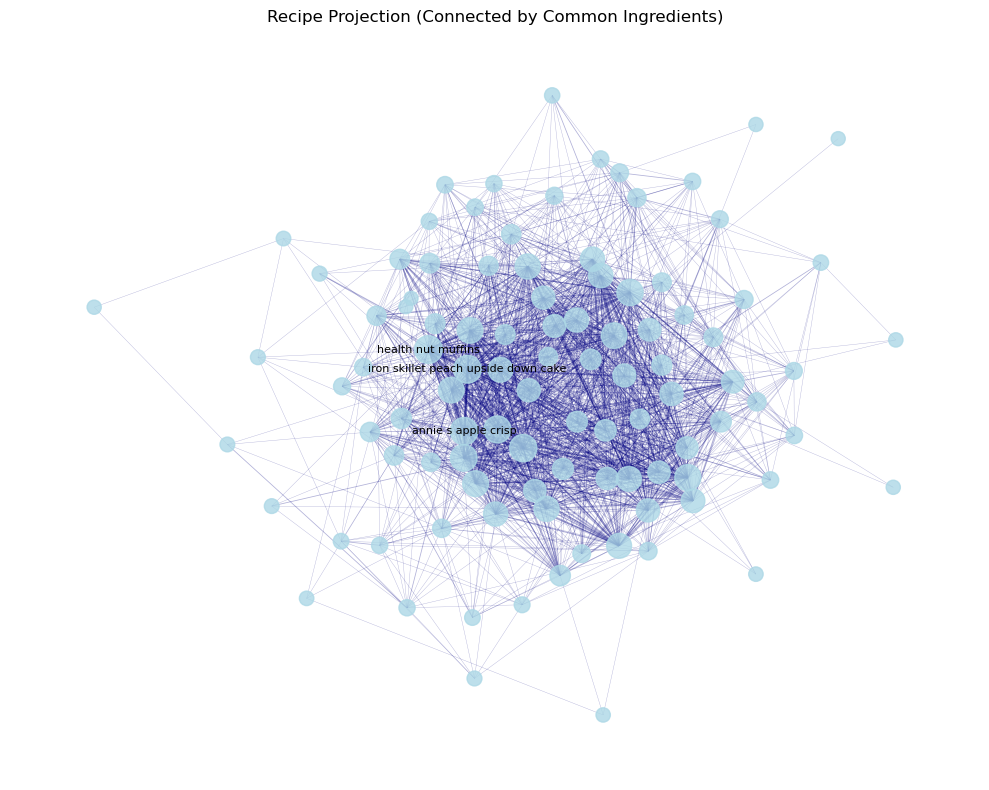

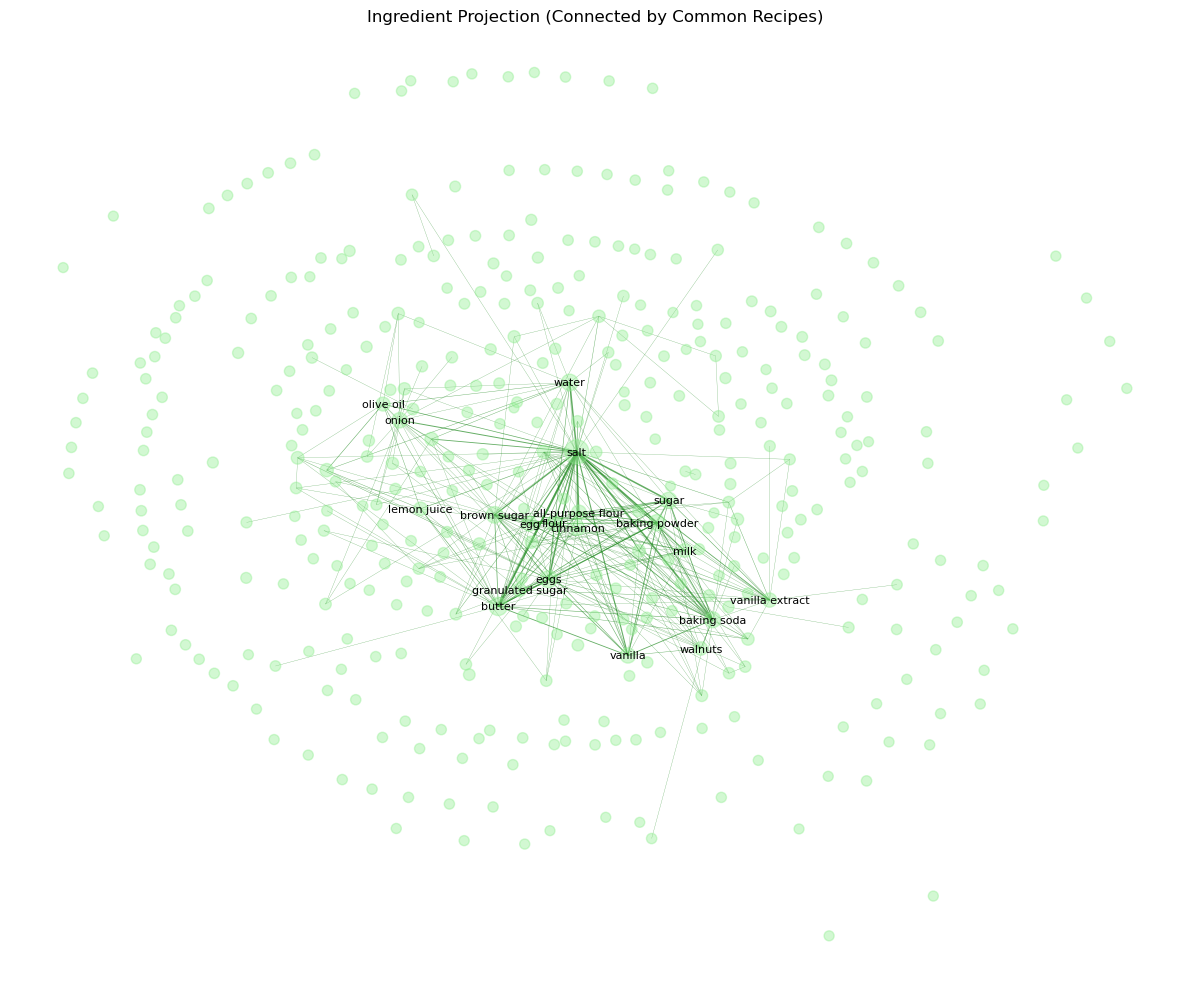

In [30]:
recipe_name_map = dict(zip(df_subset['id'], df_subset['name']))
results = analyze_bipartite_network(B, recipe_name_map)

### key analysis results
print("-------------------------")
print("Recipe Projection Analysis:")
for key, value in results['analysis']['recipes'].items():
    if not isinstance(value, dict):
        print(f"- {key}: {value}")

print("-------------------------")
print("Ingredient Projection Analysis:")
for key, value in results['analysis']['ingredients'].items():
    if not isinstance(value, dict):
        print(f"- {key}: {value}")

### top ingredients by weighted degree
print("-------------------------")
top_ingredients = sorted(results['analysis']['ingredients']['weighted_degree'].items(),
                        key=lambda x: x[1], reverse=True)[:5]
print("Top ingredients by weighted degree:")
for ing, degree in top_ingredients:
    print(f"- {ing}: {degree}")

In [31]:
# Create cuisine list 
cuisine_list = np.array(['north-american', 'mexican', 'american', 'northeastern-united-states', 
                         'amish-mennonite', 'canadian', 'south-west-pacific', 'hawaiian', 
                         'southwestern-united-states', 'asian', 'indian', 'californian', 'german', 
                         'european', 'italian', 'midwestern', 'southern-united-states', 'indonesian', 
                         'pacific-northwest', 'polish', 'chinese', 'british-columbian', 'danish', 
                         'scandinavian', 'swiss', 'swedish', 'french', 'african', 'creole', 
                         'cajun', 'australian', 'caribbean', 'central-american', 'english', 'quebec', 
                         'middle-eastern', 'lebanese', 'greek', 'south-american', 'russian', 'baja', 
                         'japanese', 'native-american', 'spanish', 'irish', 'polynesian', 'thai', 
                         'ontario', 'tex-mex', 'south-african', 'new-zealand', 'pennsylvania-dutch', 
                         'welsh', 'filipino', 'cuban', 'korean', 'belgian', 'finnish', 'moroccan', 
                         'iranian', 'persian', 'dutch', 'turkish', 'portuguese', 'hungarian', 'brazilian', 
                         'egyptian', 'vietnamese', 'norwegian', 'austrian', 'soul'])

cuisine_recipes = recipes[recipes['tags'].apply(lambda tags: any(tag in cuisine_list for tag in tags))]
cuisine_recipes['tags']

0         [60-minutes-or-less, time-to-make, course, mai...
1         [30-minutes-or-less, time-to-make, course, mai...
4         [weeknight, time-to-make, course, main-ingredi...
5         [15-minutes-or-less, time-to-make, course, mai...
6         [15-minutes-or-less, time-to-make, course, mai...
                                ...                        
231624    [15-minutes-or-less, time-to-make, course, mai...
231625    [60-minutes-or-less, time-to-make, course, mai...
231626    [weeknight, time-to-make, course, main-ingredi...
231629    [15-minutes-or-less, time-to-make, course, cui...
231631    [ham, 60-minutes-or-less, time-to-make, course...
Name: tags, Length: 91102, dtype: object

In [32]:
len(cuisine_list)

71

In [34]:
# Keep only recipes with top ten cuisines 

tags = {tag:val for (tag, val) in tags_raw.items() if val > 150}
sorted_tags = dict(sorted(tags.items(), key=lambda item: item[1], reverse=True))
cuisine_tags = {tag: val for tag, val in sorted_tags.items() if tag in cuisine_list}
top_10_cuisines_list = list(cuisine_tags.items())[:10]
top_10_cuisines = [cuisine for cuisine, _ in top_10_cuisines_list]

print(top_10_cuisines)

cuisine_recipes_top = cuisine_recipes[cuisine_recipes['tags'].apply(lambda tags: any(tag in top_10_cuisines for tag in tags))]

['north-american', 'american', 'european', 'asian', 'italian', 'southern-united-states', 'mexican', 'canadian', 'south-west-pacific', 'southwestern-united-states']


In [35]:
# Take a subset 

n_recipes = 100
cuisine_sub = cuisine_recipes_top.sample(n=n_recipes, random_state=42)

top_cuisine_network = build_bipartite_graph(cuisine_sub)

Bipartite graph has 572 nodes and 890 edges


In [36]:
# Difference in networks with top 10 vs all 
build_bipartite_graph(cuisine_recipes)
build_bipartite_graph(cuisine_recipes_top)

Bipartite graph has 102962 nodes and 874738 edges
Bipartite graph has 98298 nodes and 828003 edges


In [37]:
# Create projections 

build_bipartite_graph(cuisine_recipes)

Bipartite graph has 102962 nodes and 874738 edges


In [40]:
# Projections 
recipe_proj_top, ingredient_proj_top = create_projections(top_cuisine_network)

In [38]:
# Centrality from ingredient projection

def get_central_ingredients(ingredient_projection, top_n=10):
    """Get the most central ingredients using degree centrality."""
    # Degree centrality
    degree = nx.degree_centrality(ingredient_projection)
    
    # Betweenness centrality
    betweenness = nx.betweenness_centrality(ingredient_projection, normalized=True)
    
    # Closeness centrality
    closeness = nx.closeness_centrality(ingredient_projection)
    
    # Eigenvector centrality (handle potential convergence issues)
    try:
        eigenvector = nx.eigenvector_centrality(ingredient_projection, max_iter=1000)
    except nx.NetworkXError:
        eigenvector = {node: 0 for node in ingredient_projection.nodes}

    # Sort and return the top N ingredients for each measure
    centrality_measures = {
        "Degree Centrality": sorted(degree.items(), key=lambda x: x[1], reverse=True)[:top_n],
        "Betweenness Centrality": sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:top_n],
        "Closeness Centrality": sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:top_n],
        "Eigenvector Centrality": sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:top_n]
    }

    avg_centrality = {
        "Degree Centrality": sum(degree.values()) / len(degree),
        "Betweenness Centrality": sum(betweenness.values()) / len(betweenness),
        "Closeness Centrality": sum(closeness.values()) / len(closeness),
        "Eigenvector Centrality": sum(eigenvector.values()) / len(eigenvector)
    }

    return centrality_measures, avg_centrality

In [41]:
# Centrality measures for top 10 cuisines 
top_central_ingredients, avg_central_ingredients = get_central_ingredients(ingredient_proj_top, top_n=10)

# Print the most central ingredients nicely
for measure, ingredients in top_central_ingredients.items():
    print(f"\nTop 10 Ingredients by {measure}: ")
    for rank, (ingredient, score) in enumerate(ingredients, start=1):
        print(f"{rank}. {ingredient}: {score:.4f}")

print(avg_central_ingredients)


Top 10 Ingredients by Degree Centrality: 
1. salt: 0.4352
2. water: 0.2718
3. olive oil: 0.2718
4. butter: 0.2548
5. sugar: 0.2399
6. brown sugar: 0.2208
7. eggs: 0.1911
8. parmesan cheese: 0.1783
9. flour: 0.1783
10. garlic: 0.1741

Top 10 Ingredients by Betweenness Centrality: 
1. salt: 0.1745
2. water: 0.1230
3. butter: 0.1006
4. brown sugar: 0.0907
5. olive oil: 0.0799
6. sugar: 0.0705
7. parmesan cheese: 0.0573
8. garlic: 0.0417
9. onion: 0.0406
10. black pepper: 0.0366

Top 10 Ingredients by Closeness Centrality: 
1. salt: 0.6197
2. water: 0.5647
3. butter: 0.5594
4. brown sugar: 0.5548
5. olive oil: 0.5548
6. sugar: 0.5464
7. flour: 0.5328
8. eggs: 0.5280
9. onion: 0.5268
10. parmesan cheese: 0.5263

Top 10 Ingredients by Eigenvector Centrality: 
1. salt: 0.2945
2. olive oil: 0.2018
3. water: 0.1828
4. butter: 0.1807
5. sugar: 0.1763
6. flour: 0.1752
7. brown sugar: 0.1684
8. eggs: 0.1619
9. parmesan cheese: 0.1425
10. onions: 0.1398
{'Degree Centrality': 0.03452805066753043, '

In [43]:
# Narrow cuisines 

best_three = (['american', 'italian', 'mexican'])
print(best_three)

cuisine_recipes_top_three = cuisine_recipes[cuisine_recipes['tags'].apply(lambda tags: any(tag in best_three for tag in tags))]

['american', 'italian', 'mexican']


In [44]:
# Ingredient projection of top three cuisines 

n_recipes = 100
cuisine_sub_three = cuisine_recipes_top_three.sample(n=n_recipes, random_state=42)

top_three_cuisine_network = build_bipartite_graph(cuisine_sub_three)

recipe_proj_top_three, ingredient_proj_top_three = create_projections(top_three_cuisine_network)

recipe_proj_top_three_2, ingredient_proj_top_three_2 = create_projections(top_three_cuisine_network)

Bipartite graph has 550 nodes and 896 edges


In [45]:
# Removing most popular ingredients 

ingredient_proj_top_three.remove_node('water')
ingredient_proj_top_three.remove_node('salt')
ingredient_proj_top_three.remove_node('butter')
ingredient_proj_top_three.remove_node('olive oil')
ingredient_proj_top_three.remove_node('pepper')
ingredient_proj_top_three.remove_node('black pepper')
ingredient_proj_top_three.remove_node('sugar')

In [46]:
# American, mexican, and italian top ingredients by type of centrality 

top_three_central_ingredients, top_three_avg_ingredients = get_central_ingredients(ingredient_proj_top_three, top_n=10)

# Print the most central ingredients nicely
for measure, ingredients in top_three_central_ingredients.items():
    print(f"\nTop 10 Ingredients by {measure}: ")
    for rank, (ingredient, score) in enumerate(ingredients, start=1):
        print(f"{rank}. {ingredient}: {score:.4f}")


Top 10 Ingredients by Degree Centrality: 
1. onion: 0.3982
2. garlic cloves: 0.2217
3. brown sugar: 0.1833
4. eggs: 0.1742
5. flour: 0.1697
6. milk: 0.1674
7. parmesan cheese: 0.1629
8. garlic: 0.1538
9. ground cumin: 0.1448
10. celery: 0.1380

Top 10 Ingredients by Betweenness Centrality: 
1. onion: 0.2409
2. garlic cloves: 0.0870
3. eggs: 0.0757
4. brown sugar: 0.0666
5. flour: 0.0482
6. milk: 0.0440
7. parmesan cheese: 0.0369
8. garlic: 0.0365
9. potatoes: 0.0365
10. ground cumin: 0.0299

Top 10 Ingredients by Closeness Centrality: 
1. onion: 0.5907
2. garlic cloves: 0.5109
3. eggs: 0.4936
4. milk: 0.4918
5. flour: 0.4918
6. brown sugar: 0.4833
7. celery: 0.4740
8. worcestershire sauce: 0.4723
9. parmesan cheese: 0.4695
10. salt and pepper: 0.4661

Top 10 Ingredients by Eigenvector Centrality: 
1. onion: 0.3431
2. garlic cloves: 0.2022
3. parmesan cheese: 0.1807
4. ground cumin: 0.1559
5. flour: 0.1557
6. milk: 0.1529
7. celery: 0.1525
8. garlic: 0.1487
9. worcestershire sauce: 0.1

In [47]:
# Clustering coeff for top 30 ingredients 
degrees = dict(ingredient_proj_top_three_2.degree())
    
top_ingred = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:30]
top_ingred_nodes = [ingredient for ingredient, _ in top_ingred]
subgraph = ingredient_proj_top_three_2.subgraph(top_ingred_nodes)
clustering_coeffs = nx.clustering(subgraph)
avg_clustering = sum(clustering_coeffs.values()) / len(clustering_coeffs)
print("Clustering Coefficients for Top 30 Ingredients: ")
for ingredient, coeff in clustering_coeffs.items():
    print(f"{ingredient}: {coeff:.4f}")

# Average cliquishness for top 30 ingredients 
print(f"Average Cliquishness for Top 30 Ingredients (Clustering Coefficient): {avg_clustering:.4f}")

Clustering Coefficients for Top 30 Ingredients: 
worcestershire sauce: 0.6257
sugar: 0.8000
garlic: 0.8286
salt: 0.5320
salt and pepper: 0.7143
eggs: 0.7083
potatoes: 0.7253
butter: 0.6684
bay leaves: 0.9011
vegetable oil: 0.9722
brown sugar: 0.7363
onion: 0.5450
ground cumin: 0.7721
dried oregano: 0.9121
milk: 0.7417
bacon: 0.7636
celery: 0.7132
garlic cloves: 0.5652
tomatoes: 0.7368
fresh basil: 0.8222
fresh ground black pepper: 0.8222
black pepper: 0.8182
flour: 0.7353
parmesan cheese: 0.6619
olive oil: 0.5906
extra virgin olive oil: 0.7636
cayenne pepper: 0.8132
water: 0.5499
honey: 0.7857
pepper: 0.8022
Average Cliquishness for Top 30 Ingredients (Clustering Coefficient): 0.7376


In [48]:
# Connected components and giant component 

print(nx.number_connected_components(ingredient_proj_top_three_2))
giant = sorted(nx.connected_components(ingredient_proj_top_three_2), key=len, reverse=True)[0]
print(len(giant))

7
432


In [49]:
# Clustering coeff for bottom thirty ingredients 
bot_ingred = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[-30:]
bot_ingred_nodes = [ingredient for ingredient, _ in bot_ingred]
subgraph1 = ingredient_proj_top_three_2.subgraph(bot_ingred_nodes)
clustering_coeffs1 = nx.clustering(subgraph1)
avg_clustering1 = sum(clustering_coeffs1.values()) / len(clustering_coeffs1)
print("Clustering Coefficients for Bottom 30 Ingredients: ")
for ingredient, coeff in clustering_coeffs1.items():
    print(f"{ingredient}: {coeff:.4f}")

# Maybe just talk about this number
print(f"Average Cliquishness For Less Popular Ingredients: {avg_clustering1:.4f}")

Clustering Coefficients for Bottom 30 Ingredients: 
vanilla yogurt: 0.0000
refried beans: 0.0000
italian breadcrumbs: 1.0000
orange bell peppers: 1.0000
cabbage: 0.0000
amaretto: 0.0000
red bell peppers: 1.0000
raspberry jam: 0.0000
ice cubes: 1.0000
clementine: 0.0000
peach soda: 0.0000
bacon grease: 0.0000
jiffy corn muffin mix: 0.0000
vanilla liqueur: 1.0000
pepsi: 1.0000
dried onion flakes: 0.0000
vanilla schnapps: 1.0000
italian salad dressing: 1.0000
chicken parts: 1.0000
beer: 0.0000
eggnog: 0.0000
sodium-free beef bouillon granules: 0.0000
orange soda: 1.0000
creamed corn: 0.0000
peaches: 0.0000
yellow bell peppers: 1.0000
sweet pickles: 0.0000
caster sugar: 0.0000
semi-sweet chocolate chips: 0.0000
ice: 1.0000
Average Cliquishness For Less Popular Ingredients: 0.4000


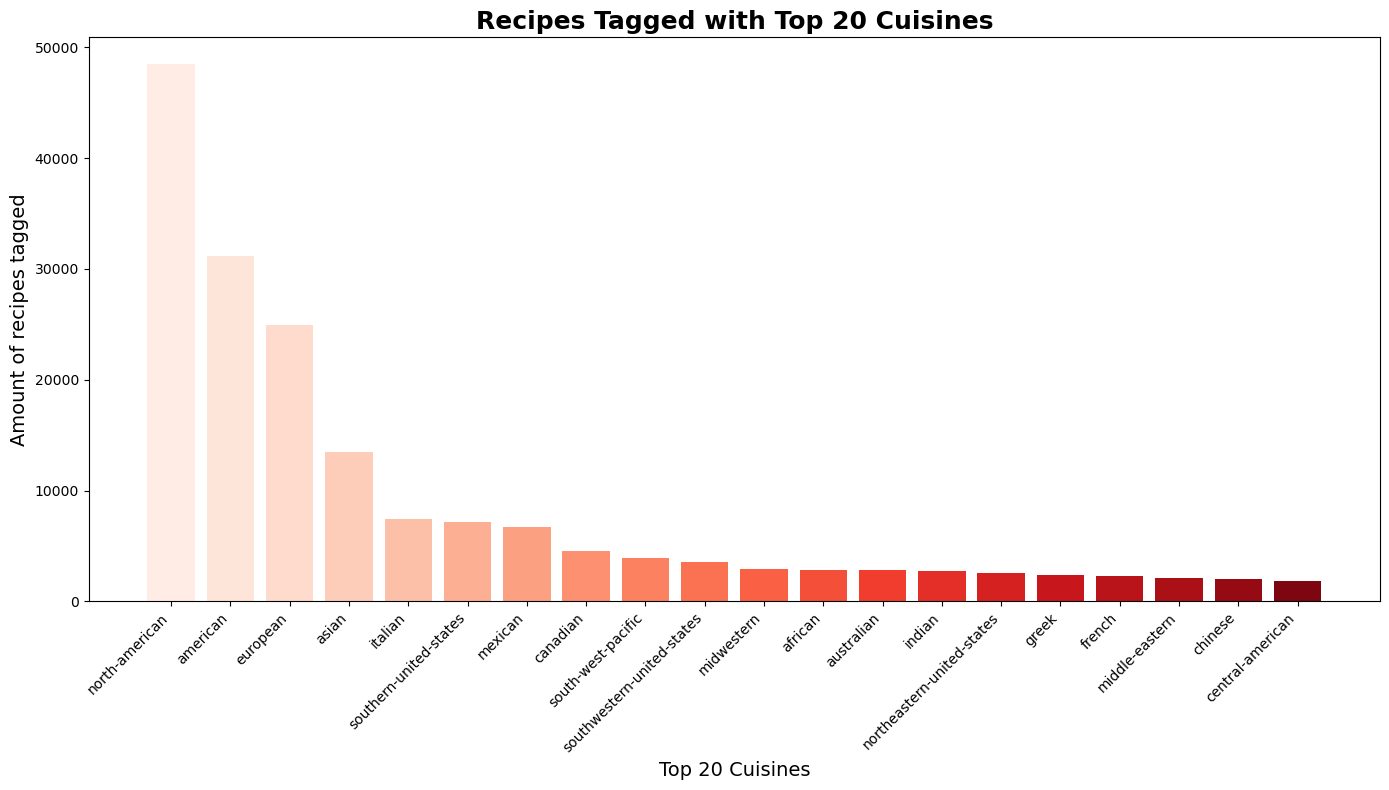

In [50]:
# Graph for amount of recipes of certain cuisines 
top_20 = {k: v for i, (k, v) in enumerate(cuisine_tags.items()) if i < 20}


plt.figure(figsize=(14, 8))
colors = sns.color_palette("Reds", len(top_20))
bars = plt.bar(range(len(top_20)), list(top_20.values()), align='center', color = colors)
plt.xticks(range(len(top_20)), list(top_20.keys()), rotation = 45, ha = 'right')
plt.title("Recipes Tagged with Top 20 Cuisines", fontsize = 18, weight = "bold")
plt.xlabel("Top 20 Cuisines", fontsize = 14)
plt.ylabel("Amount of recipes tagged", fontsize = 14)
plt.tight_layout()
plt.show()

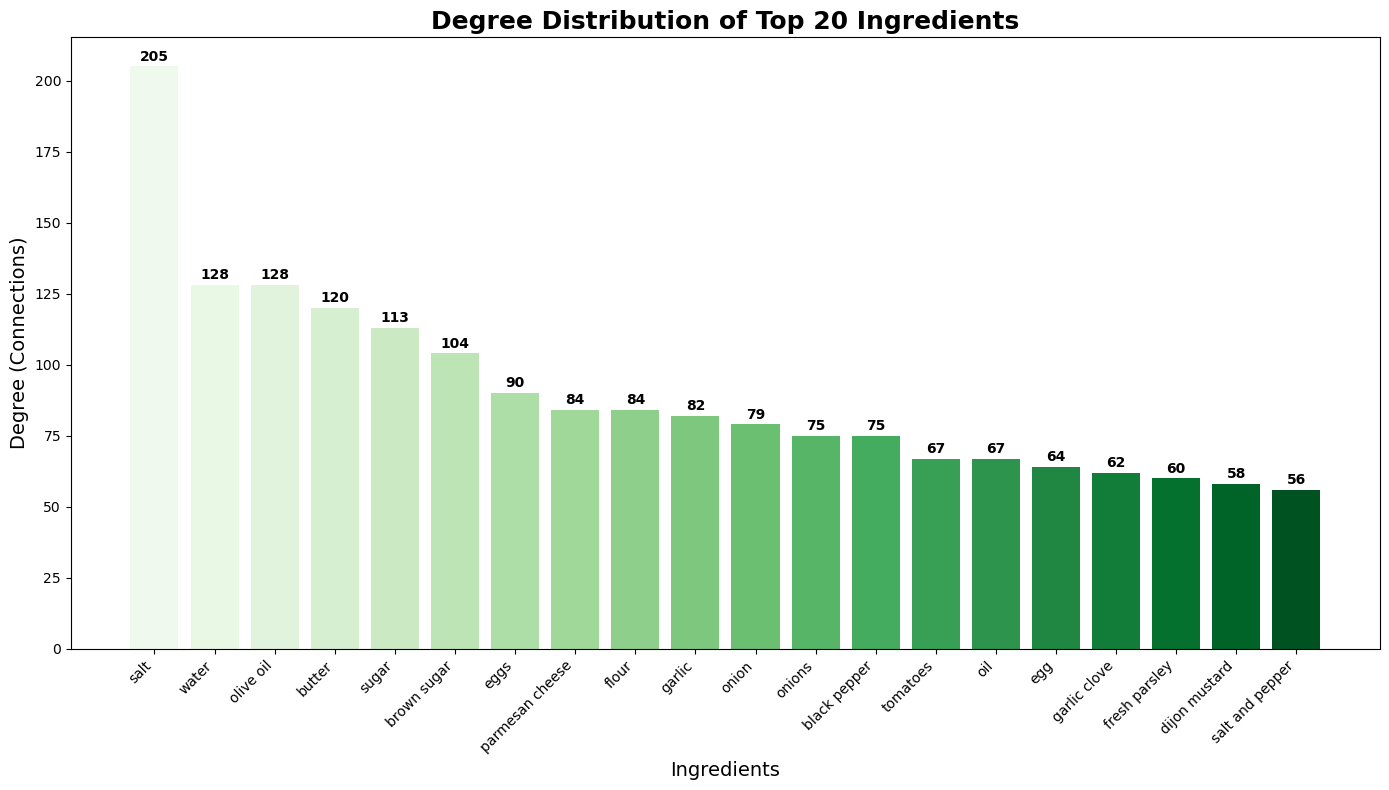

In [51]:
# Graph for degree distribution of top 20 ingredients 

degrees = dict(ingredient_proj_top.degree())
    
top_ingredients = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:20]
    
ingredients, degree_values = zip(*top_ingredients)

plt.figure(figsize=(14, 8))
    
colors = sns.color_palette("Greens", len(ingredients))
bars = plt.bar(ingredients, degree_values, color=colors)

        
plt.title(f"Degree Distribution of Top 20 Ingredients", fontsize=18, weight='bold')
plt.xlabel("Ingredients", fontsize=14)
plt.ylabel("Degree (Connections)", fontsize=14)
plt.xticks(rotation=45, ha='right')
    
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Temporal analysis 

def food_over_time_bar(df: pd.DataFrame, food:str):
    recipes_df = df.copy()
    recipes_df["temp"] = recipes_df.ingredients.apply(lambda x: food.lower() in x)
    
    m_grouped = recipes_df.groupby(pd.Grouper(key='submitted', freq='6M'))["temp"].mean().reset_index()

    # Ensure submitted column is a datetime type
    m_grouped["submitted"] = pd.to_datetime(m_grouped["submitted"])
    m_grouped["temp"] *= 100

    f, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Adjust width for closer bars and shift positions slightly
    bar_width = 160  # Adjust this value for desired bar closeness
    ax.bar(m_grouped["submitted"], m_grouped["temp"], color='steelblue', width=bar_width)

    # Properly format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=16))  # Adjust interval as needed
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.1f}%'))
    
    ax.set_xlabel('Date')
    ax.set_ylabel(f'Recipes Containing {food} Uploaded')

    plt.show()

def food_over_time_bar_multi(df: pd.DataFrame, food1: str, food2: str, food3: str):
    recipes_df = df.copy()
    
    # Compute prevalence for all three foods
    recipes_df["food1_present"] = recipes_df.ingredients.apply(lambda x: food1.lower() in x)
    recipes_df["food2_present"] = recipes_df.ingredients.apply(lambda x: food2.lower() in x)
    recipes_df["food3_present"] = recipes_df.ingredients.apply(lambda x: food3.lower() in x)
    
    m_grouped1 = recipes_df.groupby(pd.Grouper(key='submitted', freq='6M'))["food1_present"].mean().reset_index()
    m_grouped2 = recipes_df.groupby(pd.Grouper(key='submitted', freq='6M'))["food2_present"].mean().reset_index()
    m_grouped3 = recipes_df.groupby(pd.Grouper(key='submitted', freq='6M'))["food3_present"].mean().reset_index()

    # Ensure submitted column is datetime type
    m_grouped1["submitted"] = pd.to_datetime(m_grouped1["submitted"])
    m_grouped2["submitted"] = pd.to_datetime(m_grouped2["submitted"])
    m_grouped3["submitted"] = pd.to_datetime(m_grouped3["submitted"])

    # Convert to percentage
    m_grouped1["food1_present"] *= 100
    m_grouped2["food2_present"] *= 100
    m_grouped3["food3_present"] *= 100

    f, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    bar_width = 160  # Controls bar width
    
    # Plot all three foods
    ax.bar(m_grouped1["submitted"], m_grouped1["food1_present"], color='lightgreen', width=bar_width, label=food1, alpha=0.7)
    ax.bar(m_grouped2["submitted"], m_grouped2["food2_present"], color='steelblue', width=bar_width, label=food2, alpha=0.9)
    ax.bar(m_grouped3["submitted"], m_grouped3["food3_present"], color='seagreen', width=bar_width, label=food3, alpha=0.7)
    
    # Properly format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=16))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.1f}%'))

    ax.set_xlabel('Date')
    ax.set_ylabel(r'% of Recipes Uploaded using this Food')
    ax.legend()

    plt.show()